In [1]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/omarlibs/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields
from cuts import getGeoCuts
from QA import getStats, flow

import healpy as hp
import astropy.io.fits as fits

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
Nranfiles = 3
patch = None #gama12()
reg = 'svfields' #'south', 'north', 'decals', 'des', 'svfields'
dr = 'dr9d'
if dr == 'dr9d': Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20
if reg == 'svfields': desifootprint = False
else: desifootprint = True

# for healpy
hdr          = fits.getheader(dr8pix,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

In [3]:
def gama12():
    
    return [174., 186., -3., 2.]

def test():
    
    return [174., 176., 0., 2.]

## Generate the catalogue

In [4]:
# load catalogue
#version = '2.0'
#cat =  get_sweep_whole(patch=None, dr=dr, rlimit=21.0, maskbitsource=False, bgsbits=True, opt='1', version=version) # catalogue

#'/global/cscratch1/sd/qmxp55/sweep_files/dr8_sweep_whole_r21.0_v1.0.npy'
#mastercat_dr8 = '/global/cscratch1/sd/qmxp55/sweep_files/dr8_sweep_whole_r21.0_v1.0.npy'
mastercat_dr9 = '/global/cscratch1/sd/qmxp55/sweep_files/dr9d_sweep_whole_r21.0_v2.0.npy'
cat = getBGSbits(mycatpath=mastercat_dr9, filename='dr9d_sweep_whole_r21.0_v3.0.npy', mycat=True)

---- BGSMASK key: ---- 
	 BS, 0, 1
	 MS, 1, 2
	 GC, 2, 4
	 LG, 3, 8
	 allmask, 4, 16
	 nobs, 5, 32
	 SG, 6, 64
	 SGSV, 7, 128
	 FMC, 8, 256
	 FMC2, 9, 512
	 CC, 10, 1024
	 QC_FM, 11, 2048
	 QC_FI, 12, 4096
	 QC_FF, 13, 8192
	 QC_IVAR, 14, 16384
	 bgs_any, 20, 1048576
	 bgs_bright, 21, 2097152
	 bgs_faint, 22, 4194304
	 bgs_sv_any, 30, 1073741824
	 bgs_sv_bright, 31, 2147483648
	 bgs_sv_faint, 32, 4294967296
	 bgs_sv_faint_ext, 33, 8589934592
	 bgs_sv_fibmag, 34, 17179869184
	 bgs_sv_lowq, 35, 34359738368
---- Sanity Check ---- 
	 BS, 7661115, 7661115
	 MS, 7008839, 7008839
	 GC, 7989269, 7989269
	 LG, 7978669, 7978669
	 allmask, 7431813, 7431813
	 nobs, 7496234, 7496234
	 SG, 3585586, 3585586
	 SGSV, 3590830, 3590830
	 FMC, 7888181, 7888181
	 FMC2, 7909320, 7909320
	 CC, 7380576, 7380576
	 QC_FM, 7322847, 7322847
	 QC_FI, 7492427, 7492427
	 QC_FF, 7749651, 7749651
	 QC_IVAR, 7507648, 7507648
	 bgs_any, 1047808, 1047808
	 bgs_bright, 615417, 615417
	 bgs_faint, 432391, 432391
	 bgs_sv_a

If we istead want to run our BGS script that generates the `BGSBITS` information in a predefined catalogue, run:

    cat = getBGSbits(mycatpath=<path_to_file>, filename=<outout_file_name>, mycat=True)

## Generate flow chart

### randoms

In [5]:
randoms = get_random(N=Nranfiles, sweepsize=None, dr=dr) # randoms

indesiranfile = '/global/cscratch1/sd/qmxp55/random_%s_indesi_N%s.npy' %(dr, Nranfiles)
is_indesiranfile = os.path.isfile(indesiranfile)
if is_indesiranfile: 
    ranindesi = np.load(indesiranfile)
else: 
    ranindesi = get_isdesi(randoms['RA'],randoms['DEC']) # True is is in desi footprint
    np.save(indesiranfile, ranindesi)
    
hppixranfile = '/global/cscratch1/sd/qmxp55/hppix_%s_random_N%s.npy' %(dr, Nranfiles)
is_hppixranfile = os.path.isfile(hppixranfile)
if is_hppixranfile: 
    hppix_ran = np.load(hppixranfile)
else: 
    hppix_ran = hp.ang2pix(nside,(90.-np.array(randoms['DEC']))*np.pi/180.,np.array(randoms['RA'])*np.pi/180.,nest=nest) # randoms hp pixels array
    np.save(hppixranfile, hppix_ran)

RANDOM file already exist at:/global/cscratch1/sd/qmxp55/dr9d_random_N20.npy
Total run time: 0.000203 sec
Weight of /global/cscratch1/sd/qmxp55/dr9d_random_N20.npy catalogue: 1.6 GB


In [6]:
# get regions for randoms. This is a one time thing for every release.
if dr == 'dr8-south':
    raninreg = '/global/cscratch1/sd/qmxp55/inREGIONS_randoms_%s_N%s.npy' %('dr8', Nranfiles)
else:
    raninreg = '/global/cscratch1/sd/qmxp55/inREGIONS_randoms_%s_N%s.npy' %(dr, Nranfiles)
    
is_raninreg = os.path.isfile(raninreg)
if is_raninreg:
    print('File already exists at %s' %(raninreg))
    raninregs = np.load(raninreg)
else:
    print('File does not exist yet. Computing it...')
    raninregs = {}
    regs = ['des', 'decals', 'north', 'desi', 'south', 'svfields']
    for i in regs:
        reg_ = get_reg(reg=i, hppix=hppix_ran)
        raninregs[i] = reg_
        print(i, 'DONE...')

    # save region info as npy file
    from astropy.table import Table
    tabreg = Table()

    for key in raninregs.keys():
        tabreg[key] = raninregs[key]
    
    # save astropy table as npy file
    np.save(raninreg, tabreg)
    

File already exists at /global/cscratch1/sd/qmxp55/inREGIONS_randoms_dr9d_N20.npy


In [7]:
#
if reg == 'svfields':
    raninreg = get_svfields(randoms['RA'],randoms['DEC'])
else:
    raninreg = (raninregs['desi']) & (raninregs[reg])

In [8]:
#
def keepPatch(patch, catalog):
    
    mask = np.ones_like(catalog['RA'], dtype='?')
    mask &= np.logical_and(catalog['RA'] >= patch[0], catalog['RA'] <= patch[1])
    mask &= np.logical_and(catalog['DEC'] >= patch[2], catalog['DEC'] <= patch[3])
    
    return mask


if patch is not None:
    
    keep = keepPatch(patch=patch, catalog=randoms)
    randoms = randoms[keep]
    ranindesi = ranindesi[keep]
    hppix_ran = hppix_ran[keep]
    raninreg = raninreg[keep]

else:
    keep = raninreg
    randoms = randoms[keep]
    ranindesi = ranindesi[keep]
    hppix_ran = hppix_ran[keep]
    raninreg = raninreg[keep]
    

In [10]:
#bgsmask = bgsmask()
rancuts = getGeoCuts(randoms, randoms=True)

### getting area of reg (+ patch if any) with healpix pixels

NOTE: if using SVFIELDS footprint, use `desifootprint=False` otherwise the area will be less than the current SVFIELDS due desi footprint chops out part of it.

In [11]:
#Notes: This hpdict is used to get the area only using the randoms. 
#This use the randoms within the DESI footprint and without any masking (maskrand=None) as we want the area without wholes.
hpdict = get_dict(cat=None, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                            desifootprint=desifootprint, namesels=None, target_outputs=False, log=True)

positions and desifotprint DONE...
systematics DONE...
randdens =  100000  ; len randoms =  44608767
bgsfracarea DONE...
regions DONE...
areas DONE...


### pixel info of catalogue

In [12]:
hppix_cat = hp.ang2pix(nside,(90.-cat['DEC'])*np.pi/180.,cat['RA']*np.pi/180.,nest=True) # catalogue hp pixels array

In [13]:
catindesi = get_reg(reg='desi', hppix=hppix_cat)

if reg == 'svfields':
    catinreg = get_svfields(cat['RA'], cat['DEC'])
else:
    catinreg_ = get_reg(reg=reg, hppix=hppix_cat)
    catinreg = (catindesi) & (catinreg_)

In [14]:
keep = catinreg
cat = cat[keep]
catindesi = catindesi[keep]
hppix_cat = hppix_cat[keep]
catinreg = catinreg[keep]

## Sanity checks...

In [15]:
from astropy.coordinates import SkyCoord
import astropy.units as units

c = SkyCoord(cat['RA']*units.degree,cat['DEC']*units.degree, frame='icrs')
galb = c.galactic.b.value # galb coordinate

In [16]:
#dic with default BGS selection and in DESI footprint
hpdict2 = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=desifootprint, namesels={'bgs_any':20, 'bright':21, 'faint':22}, galb=galb, log=True, survey='bgs')

positions and desifotprint DONE...
systematics DONE...
randdens =  100000  ; len randoms =  44608767
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgs_any
computing for  north / bright
computing for  north / faint
target densities in north DONE...
computing for  south / bgs_any
computing for  south / bright
computing for  south / faint
target densities in south DONE...
meandens_bgs_any_all = 1432 /deg2
meandens_bgs_any_des = nan /deg2
meandens_bgs_any_decals = 1465 /deg2
meandens_bgs_any_north = 1348 /deg2
meandens_bgs_any_south = 1465 /deg2
meandens_bgs_any_svfields = 1435 /deg2
meandens_bgs_any_svfields_n = 1353 /deg2
meandens_bgs_any_svfields_s = 1466 /deg2
meandens_bright_all = 844 /deg2
meandens_bright_des = nan /deg2
meandens_bright_decals = 866 /deg2
meandens_bright_north = 786 /deg2
meandens_bright_south = 866 /deg2
meandens_bright_svfields = 844 /deg2
meandens_bright_svfields_n = 789 /deg2
meandens_bright_svfields_s = 866 /deg2
meandens_faint_all = 5

In [17]:
from QA import mollweide, mycmap, plot_sysdens
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

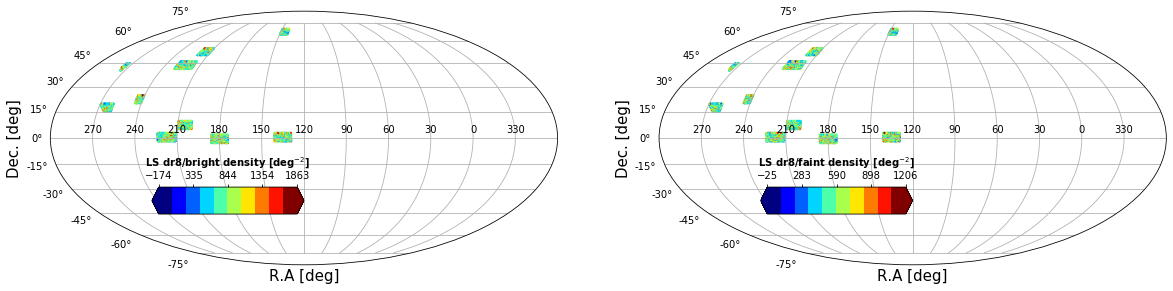

In [18]:
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(1,2)
    
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

mollweide(hpdict=hpdict2, namesel='bright', reg=reg, projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None)
mollweide(hpdict=hpdict2, namesel='faint', reg=reg, projection=projection, n=1, org=org, cm=cm, fig=fig, gs=gs, cval=None)
#mollweide(hpdict=hpdict, C=None ,namesel='any', reg='all', projection=projection, n=1, org=org, cm=cm, 
#          fig=fig, ws=ws, perc=(0.3,99.8), title='After linear weights', cval=(84, 2750))

file = 'skydens_%s_%s' %(dr, reg)
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)


In [19]:
t = getStats(cat=cat, hpdict=hpdict, bgsmask=bgsmask(), rancuts=rancuts, CurrentMask=['BS', 'LG', 'FMC2', 'allmask'], PrevMask=['SG'], 
                 reg=reg, regcat=catinreg, regran=raninreg, program='main')

Previous Cuts: (SG)
Current Cuts: (BS|LG|FMC2|allmask)


In [20]:
t

GM,$f_{A}$ [$\%$],$\eta_{B}$ [deg$^2$],$\eta_{F}$ [deg$^2$]
bytes22,float64,float64,float64
BS,3.03,48.63,14.86
LG,0.07,2.62,1.81
FMC2,0.0,26.21,19.72
allmask,0.81,141.62,11.03
(BS|LG|FMC2|allmask),3.77,190.61,45.04
~(BS|LG|FMC2|allmask)*,96.23,840.44,585.56
~(BS|LG|FMC2|allmask),96.23,873.41,608.53


## flow chart BGS main: north/south

In [21]:
#
catinnorth = get_reg(reg='north', hppix=hppix_cat)
catinsouth = get_reg(reg='south', hppix=hppix_cat)
#
raninnorth = get_reg(reg='north', hppix=hppix_ran)
raninsouth = get_reg(reg='south', hppix=hppix_ran)

In [22]:
#catinsvfield = get_reg(reg='svfields', hppix=hppix_cat)

In [23]:
bgs_bright = ((cat['BGSBITS'] & 2**(21)) != 0)
bgs_faint = ((cat['BGSBITS'] & 2**(22)) != 0)
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)

In [32]:
#Do we miss the LSLGA in BGS?
LX = cat['REF_CAT'] == 'L4'
Ared = hpdict2['bgsarea_'+reg+'_s']
AREA = hpdict['bgsarea_'+reg+'_s']

print('AREA SOUTH: \t %.2f(total) \t %.2f(reduced)' %(AREA, Ared))
print('#LSLGA in whole SWEEP SOUTH: \t %.3f' %(np.sum((LX) & (catinsouth))/Ared))
print('#LSLGA in BGS SOUTH: \t %.3f' %(np.sum((bgs_any) & (LX) & (catinsouth))/Ared))

AREA SOUTH: 	 302.07(total) 	 289.55(reduced)
#LSLGA in whole SWEEP SOUTH: 	 1.416
#LSLGA in BGS SOUTH: 	 1.416


Previous Cuts: (None)
Current Cuts: (SG)
Previous Cuts: (SG)
Current Cuts: (BS|LG|GC)
Previous Cuts: (SG|BS|LG|GC)
Current Cuts: (nobs)
Previous Cuts: (SG|BS|LG|GC|nobs)
Current Cuts: (FMC2|CC)
Previous Cuts: (SG|BS|LG|GC|nobs|FMC2|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF|QC_IVAR)


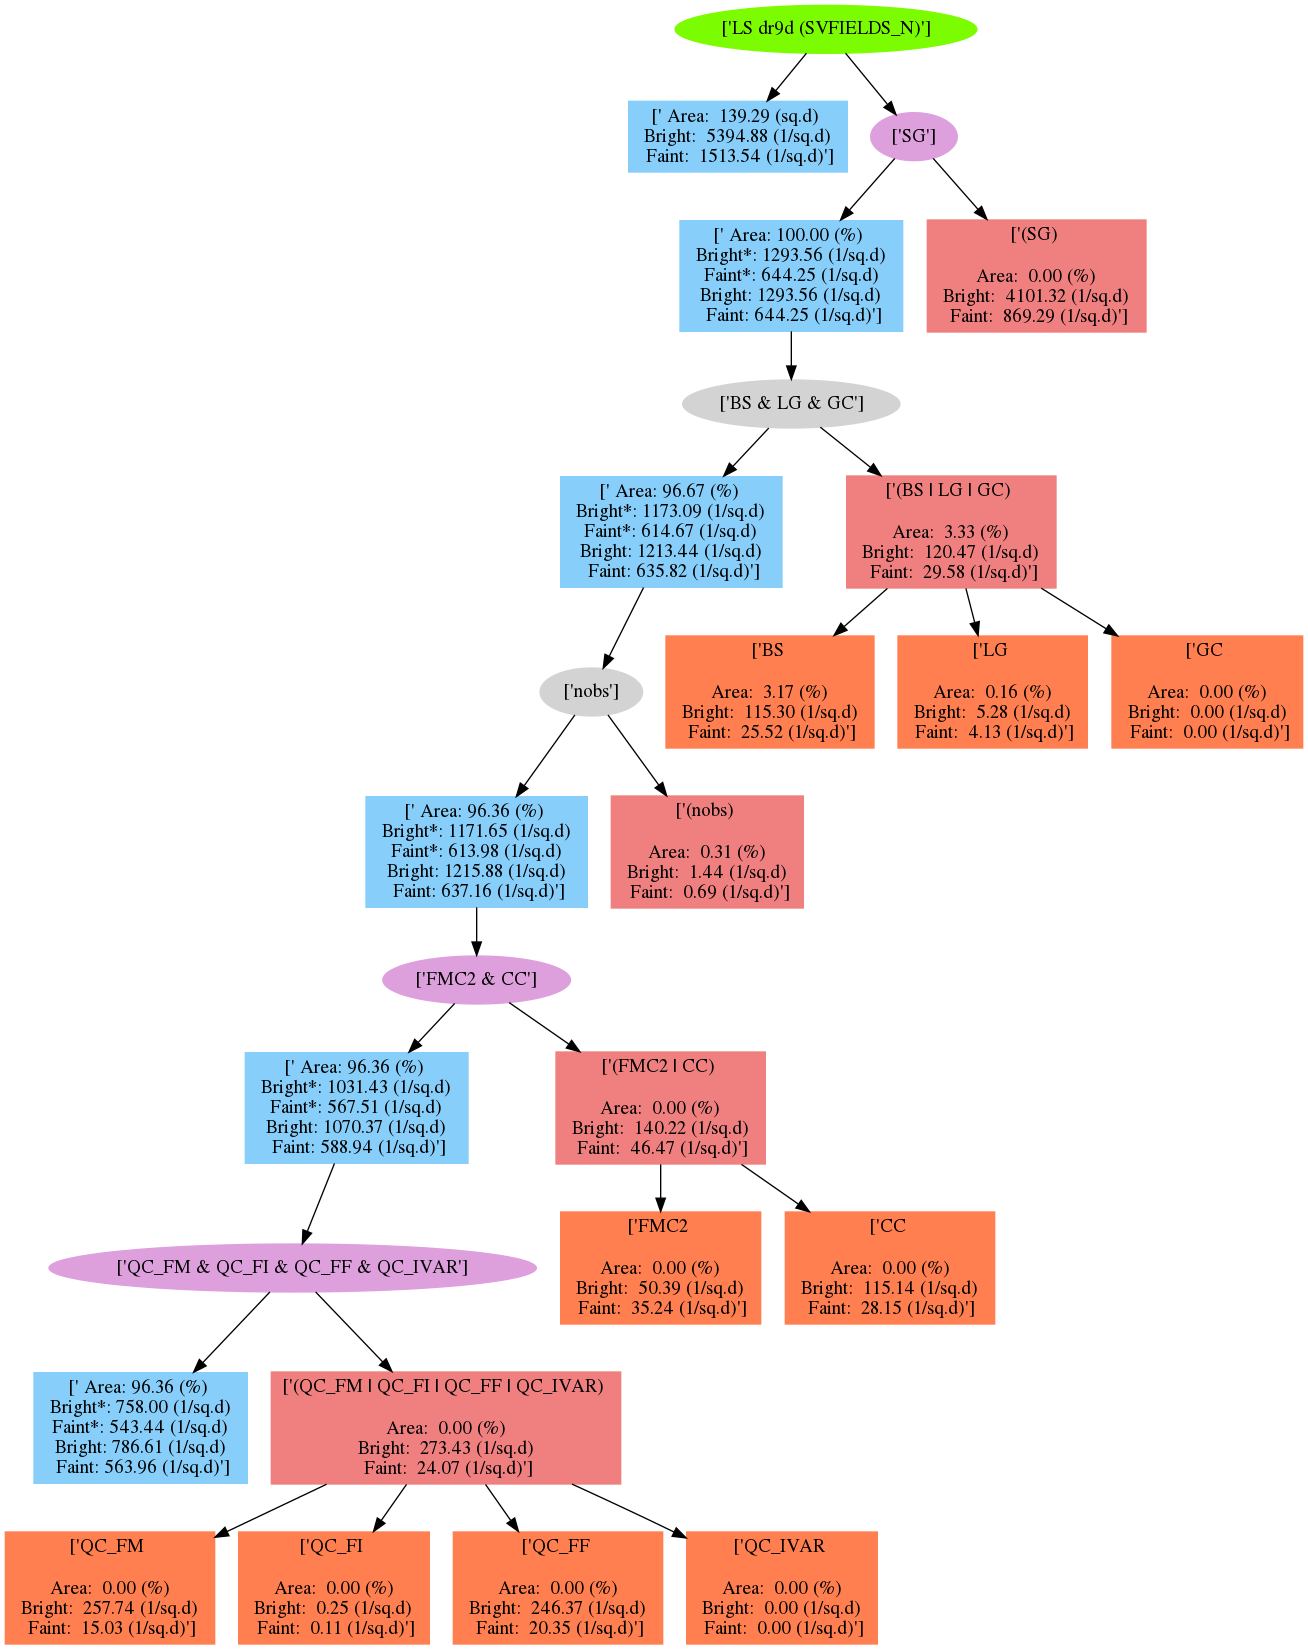

In [25]:
order = [ ['SG'], ['BS', 'LG', 'GC'], ['nobs'], ['FMC2', 'CC'], ['QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']]
#order = [['SG'], ['BS', 'MS'], ['FMC', 'CC']]
if reg == 'svfields': region = reg+'_n'
else: region = reg
flowphot, _, _ = flow(cat=cat, hpdict=hpdict, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=region, 
             regcat=(catinreg) & (catinnorth), regran=(raninreg) & (raninnorth), file='flow_main_%s_galview_north' %(dr), dr=dr, program='main')

flowphot

Previous Cuts: (None)
Current Cuts: (SG)
Previous Cuts: (SG)
Current Cuts: (BS|LG|GC)
Previous Cuts: (SG|BS|LG|GC)
Current Cuts: (nobs)
Previous Cuts: (SG|BS|LG|GC|nobs)
Current Cuts: (FMC2|CC)
Previous Cuts: (SG|BS|LG|GC|nobs|FMC2|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF|QC_IVAR)
Previous Cuts: (SG|BS|LG|GC|nobs|FMC2|CC|QC_FM|QC_FI|QC_FF|QC_IVAR)
Current Cuts: (allmask)


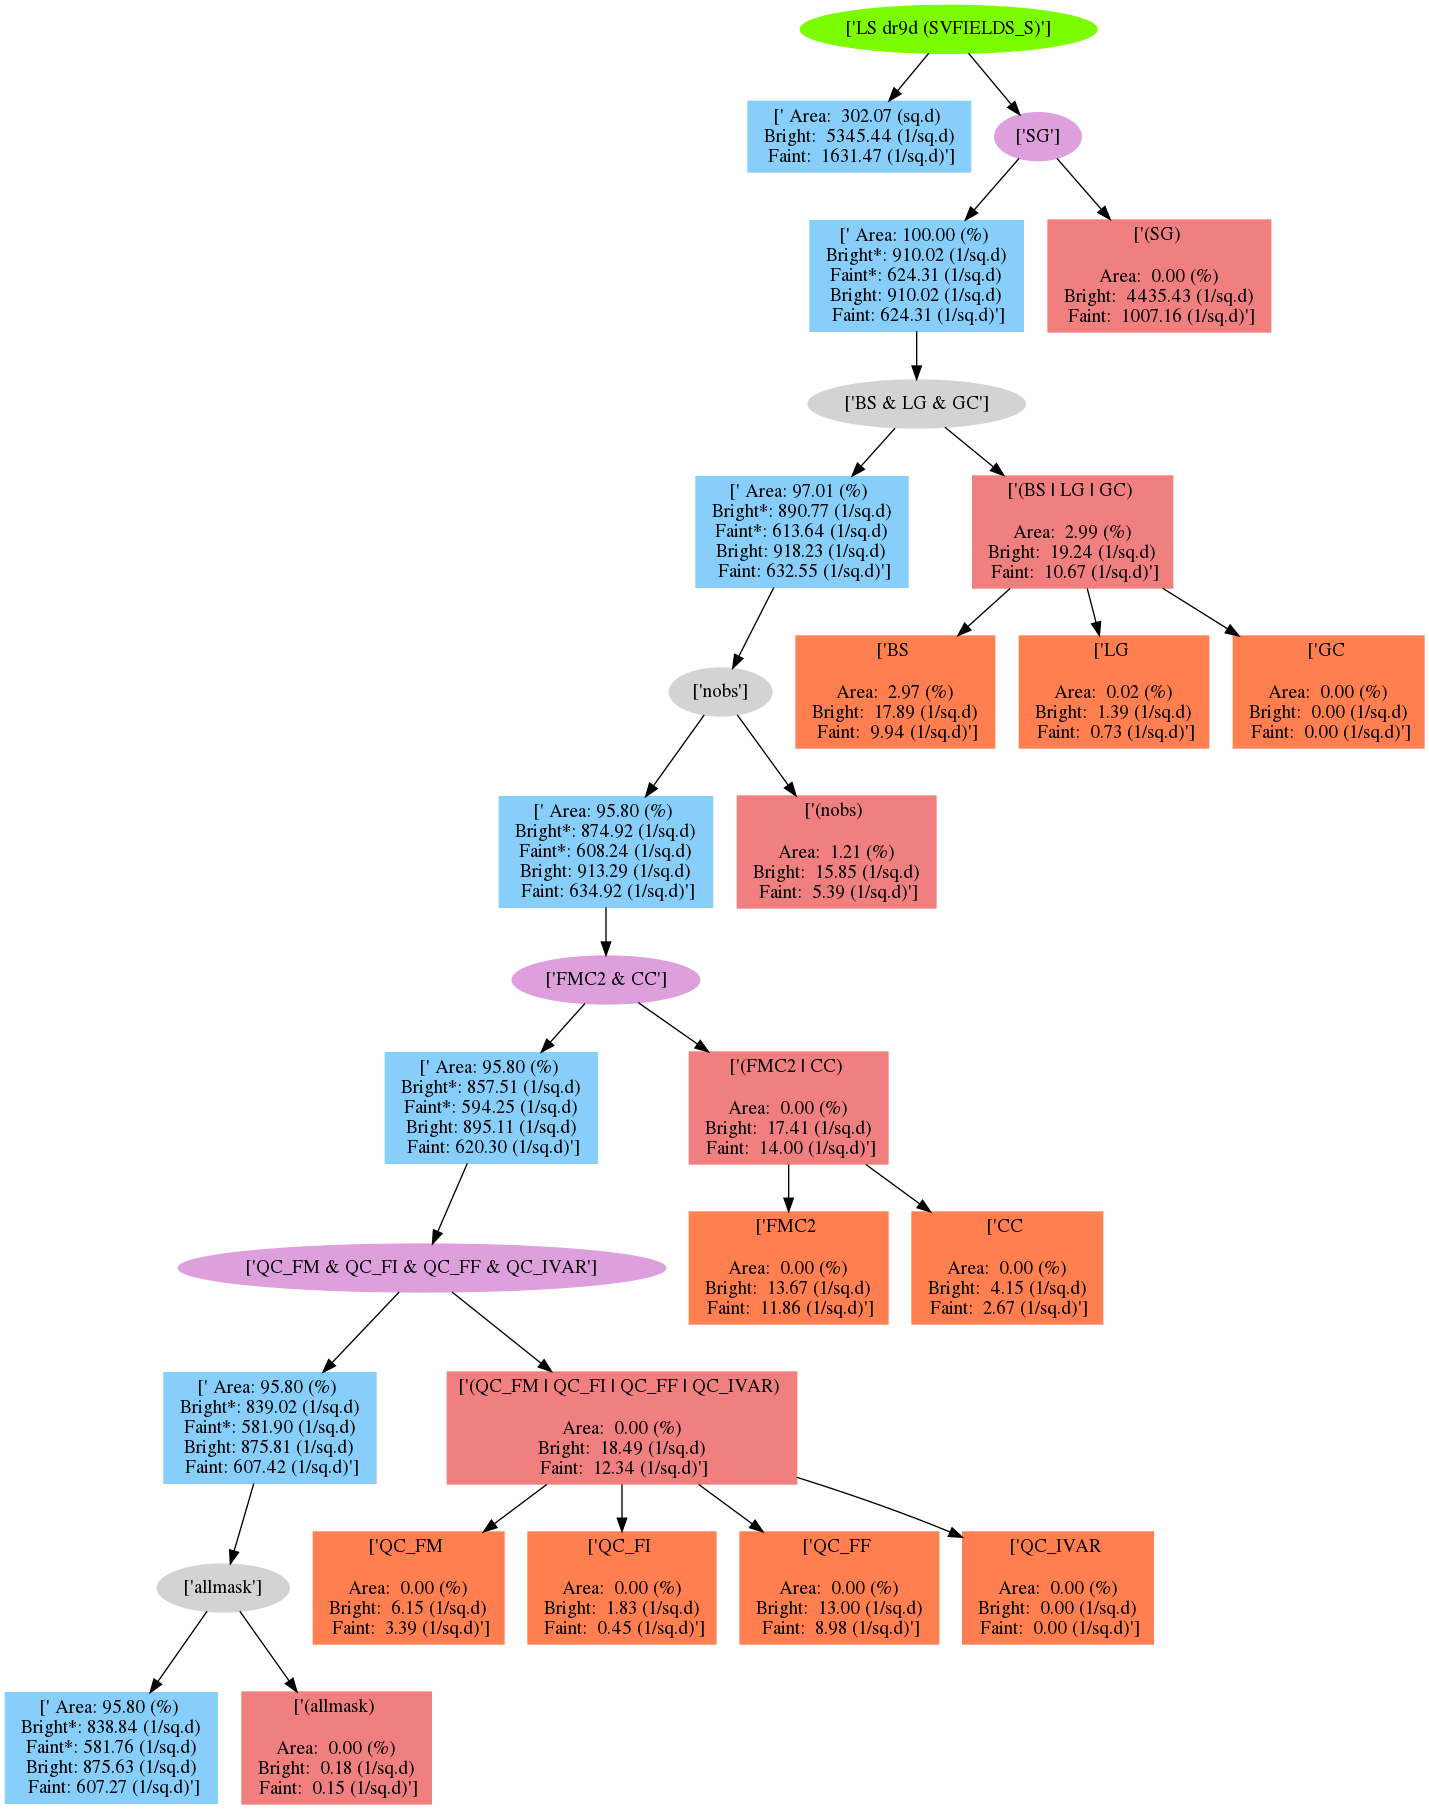

In [26]:
#
if reg == 'svfields': region = reg+'_s'
else: region = reg
order = [ ['SG'], ['BS', 'LG', 'GC'], ['nobs'], ['FMC2', 'CC'], ['QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR'], ['allmask']]
#order = [['SG'], ['BS', 'MS'], ['FMC', 'CC']]
flowphot, _, _ = flow(cat=cat, hpdict=hpdict, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=region, 
             regcat=(catinreg) & (catinsouth), regran=(raninreg) & (raninsouth), file='flow_main_%s_galview_south' %(dr), dr=dr, program='main')

flowphot

## flow chart BGS main

Previous Cuts: (None)
Current Cuts: (BS|LG|GC)
Previous Cuts: (BS|LG|GC)
Current Cuts: (nobs)
Previous Cuts: (BS|LG|GC|nobs)
Current Cuts: (SG)
Previous Cuts: (BS|LG|GC|nobs|SG)
Current Cuts: (FMC2|CC)
Previous Cuts: (BS|LG|GC|nobs|SG|FMC2|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF|QC_IVAR)


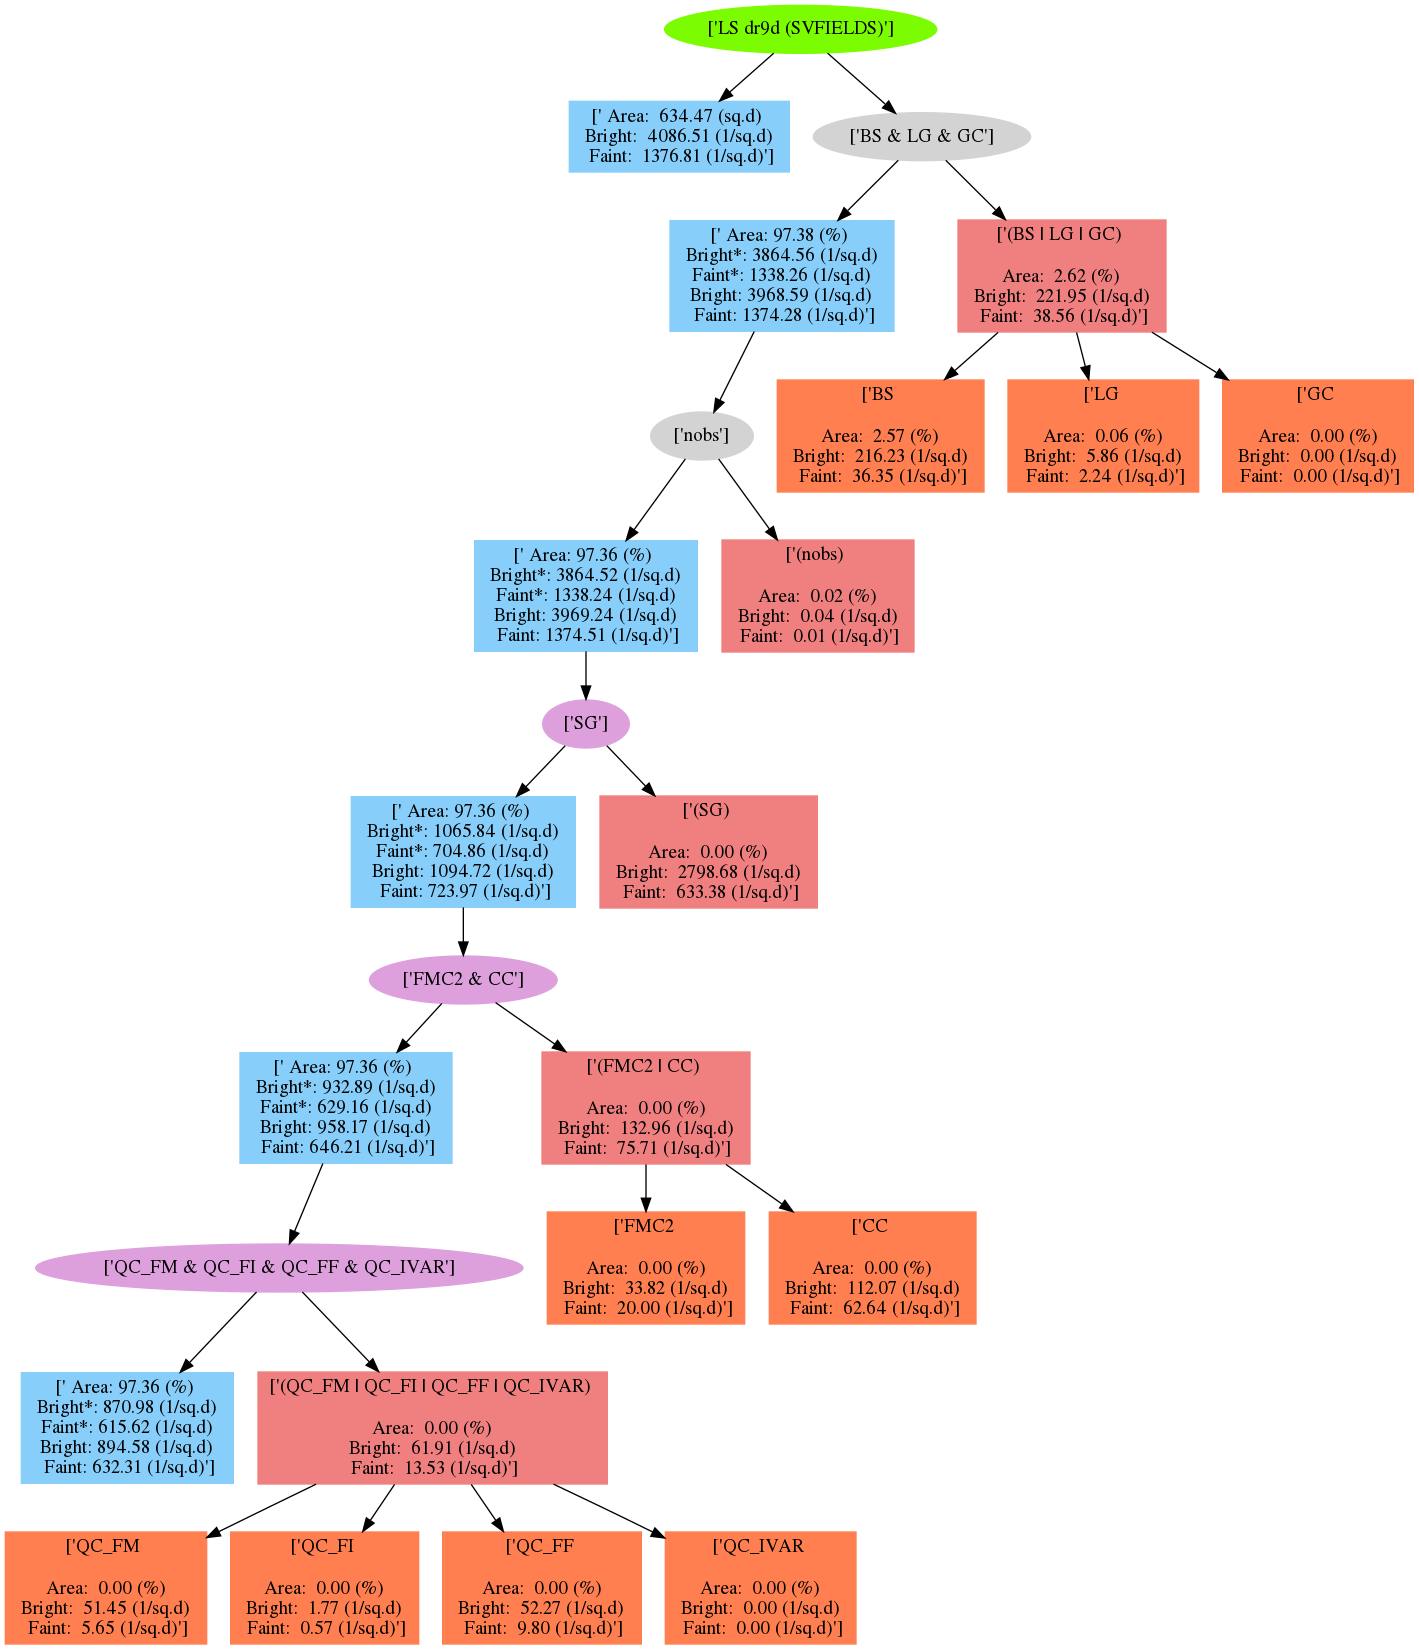

In [15]:
#
order = [['BS', 'LG', 'GC'], ['nobs'], ['SG'], ['FMC2', 'CC'], ['QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']]
#order = [['SG'], ['BS', 'MS'], ['FMC', 'CC']]
flowphot, _, _ = flow(cat=cat, hpdict=hpdict, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=reg, 
             regcat=catinreg, regran=raninreg, file='flow_main_%s_nominal' %(dr), dr=dr, program='main')

flowphot

Previous Cuts: (None)
Current Cuts: (SG)
Previous Cuts: (SG)
Current Cuts: (BS|LG|GC)
Previous Cuts: (SG|BS|LG|GC)
Current Cuts: (nobs)
Previous Cuts: (SG|BS|LG|GC|nobs)
Current Cuts: (FMC2|CC)
Previous Cuts: (SG|BS|LG|GC|nobs|FMC2|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF|QC_IVAR)


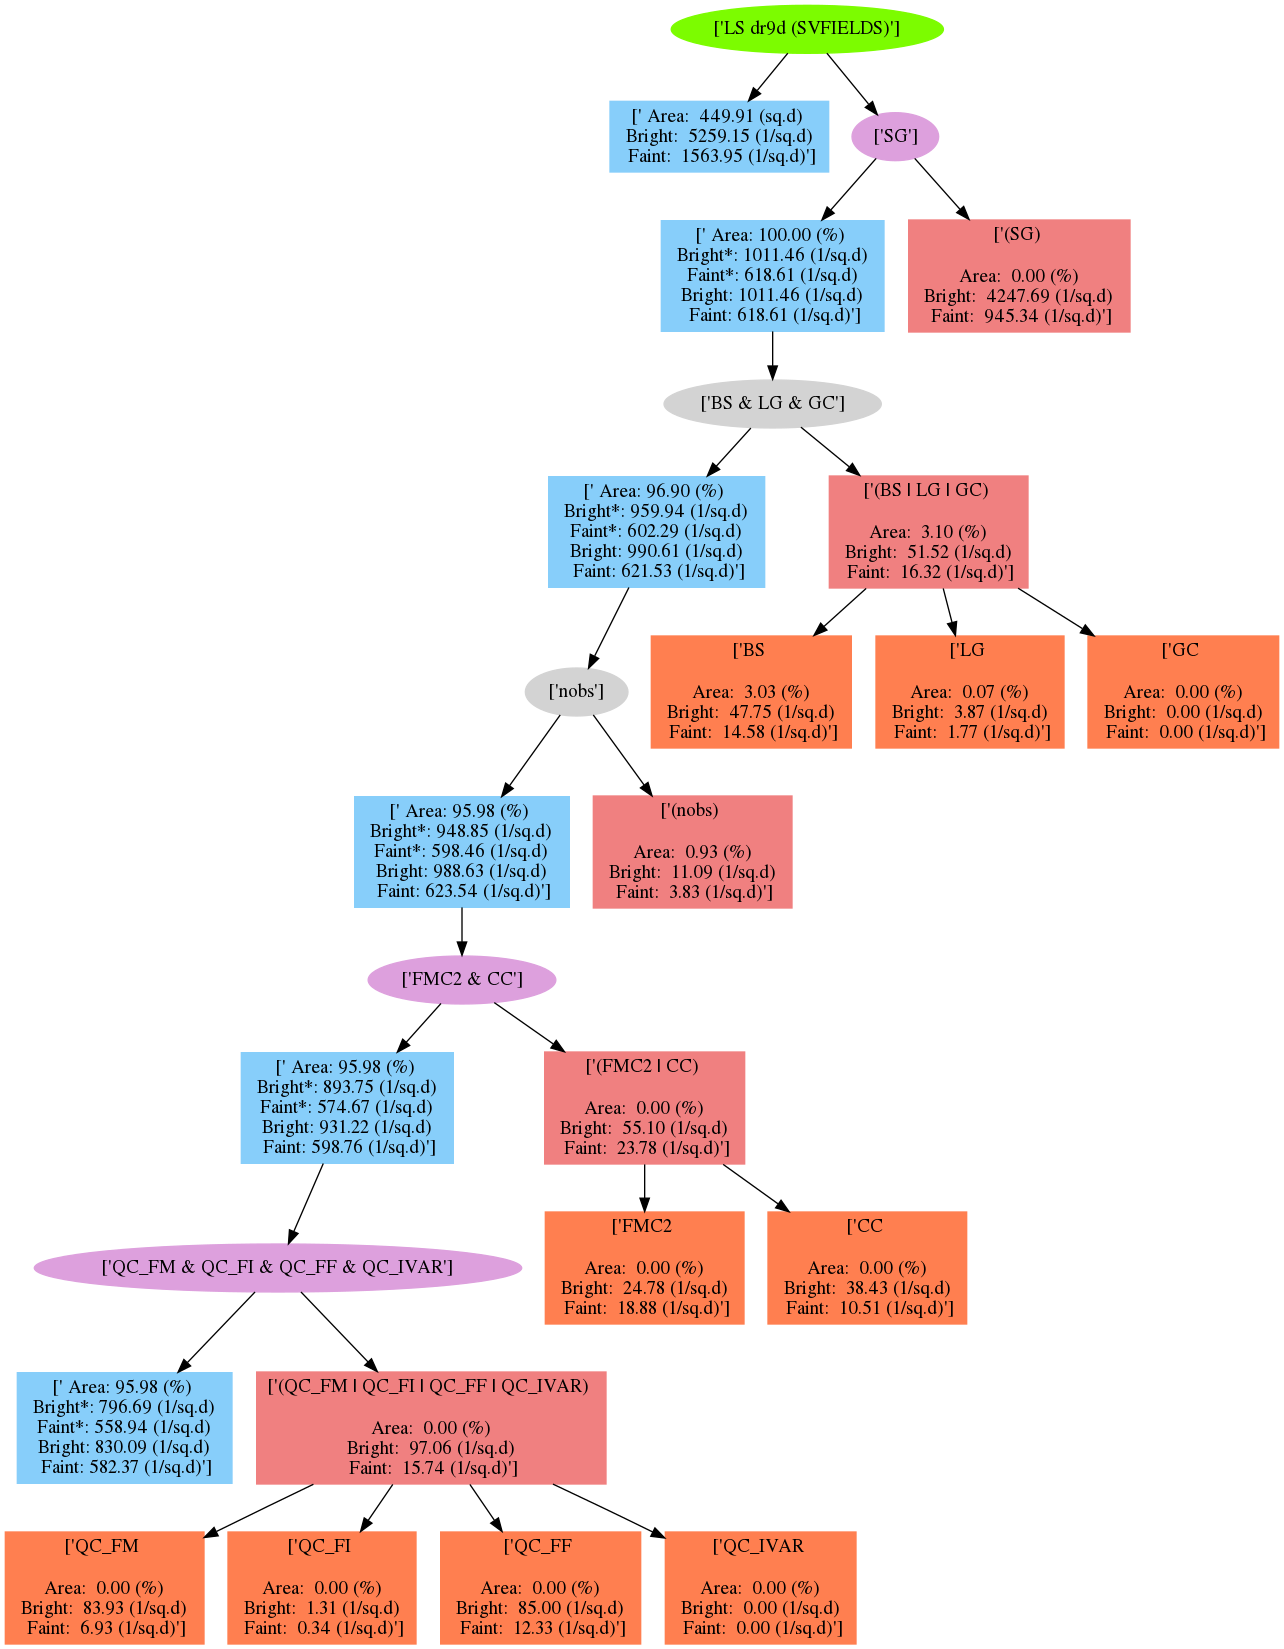

In [24]:
#
order = [ ['SG'], ['BS', 'LG', 'GC'], ['nobs'], ['FMC2', 'CC'], ['QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']]
#order = [['SG'], ['BS', 'MS'], ['FMC', 'CC']]
flowphot, _, _ = flow(cat=cat, hpdict=hpdict, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=reg, 
             regcat=catinreg, regran=raninreg, file='flow_main_%s_galview' %(dr), dr=dr, program='main')

flowphot

## flow chart BGS SV

Previous Cuts: (None)
Current Cuts: (BS)
Previous Cuts: (BS)
Current Cuts: (nobs)
Previous Cuts: (BS|nobs)
Current Cuts: (SGSV)
Previous Cuts: (BS|nobs|SGSV)
Current Cuts: (CC)
Previous Cuts: (BS|nobs|SGSV|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF|QC_IVAR)


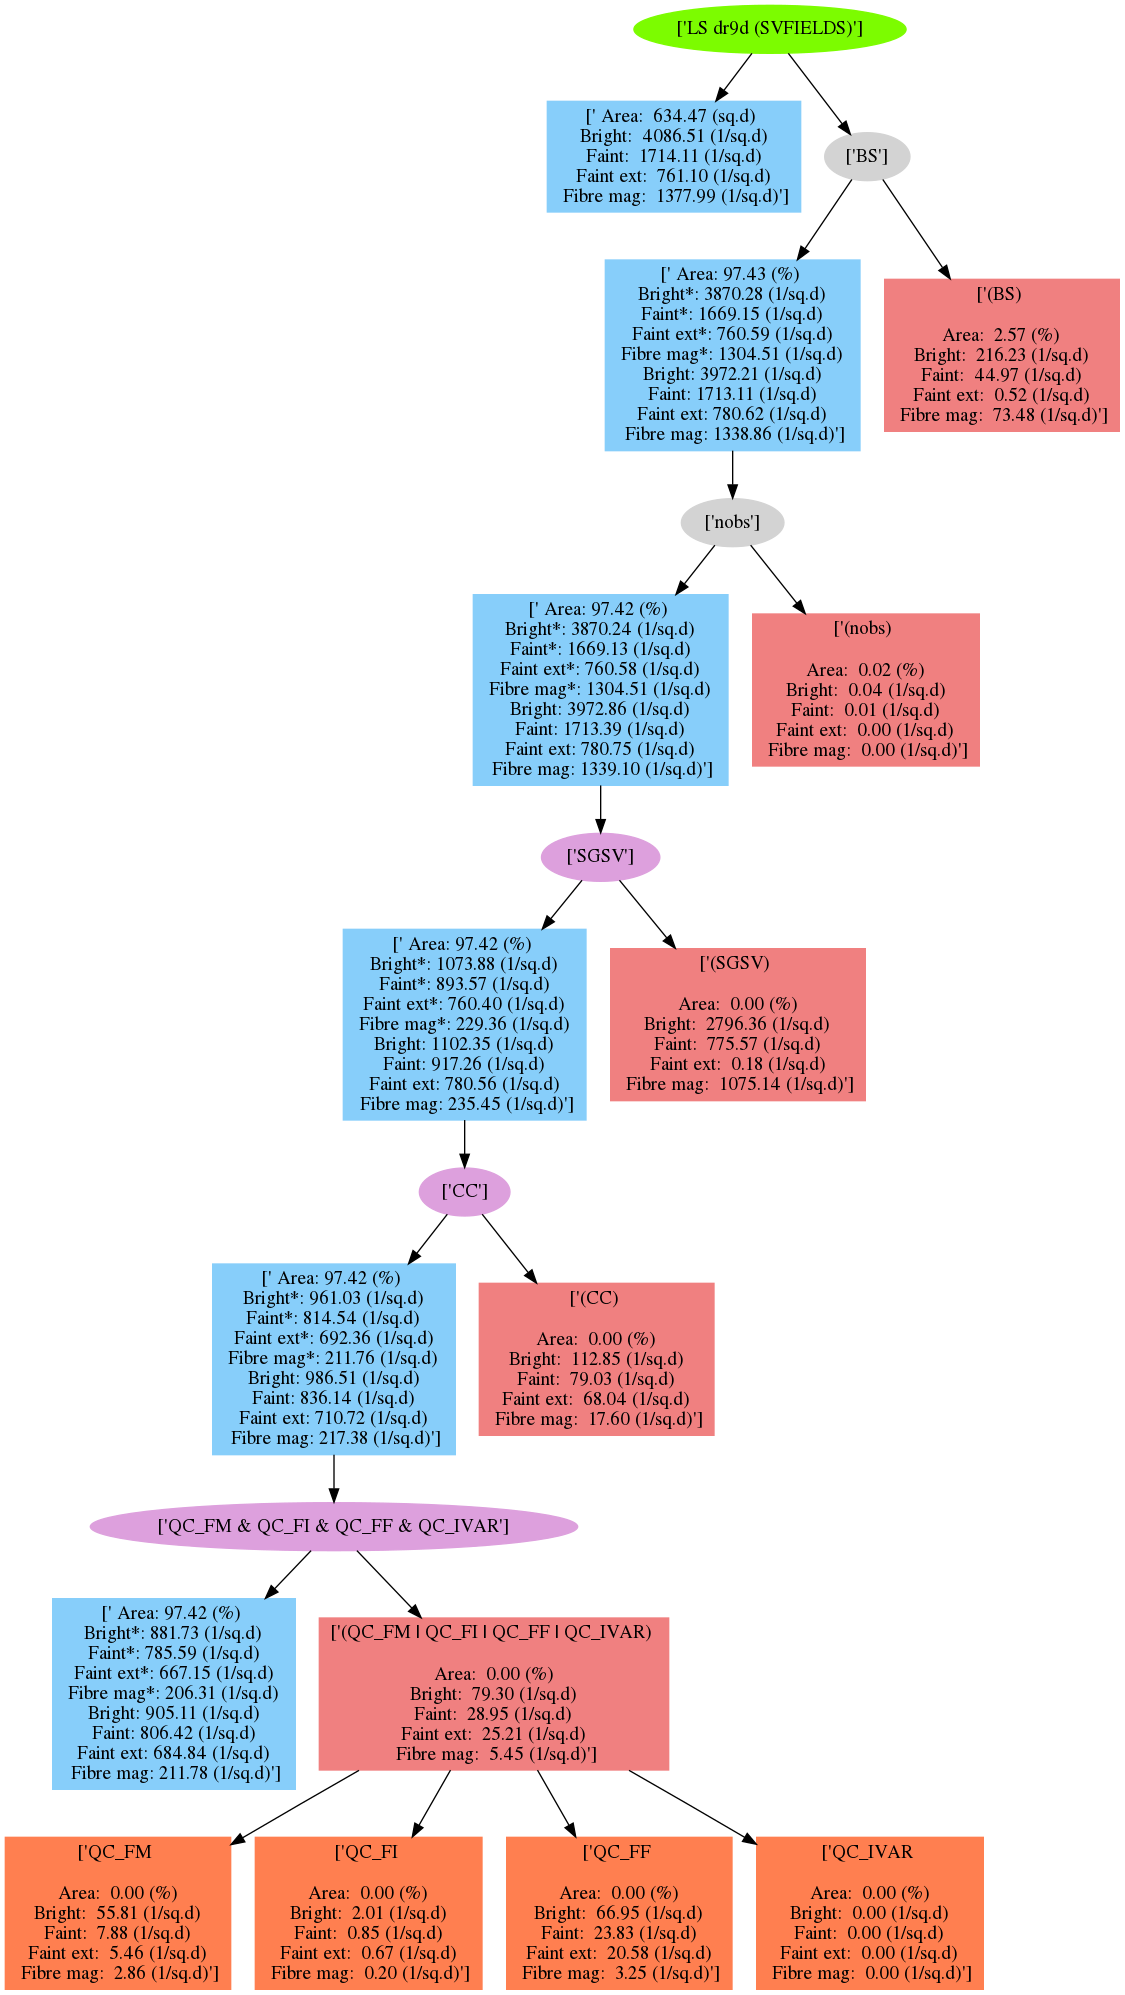

In [17]:
#
order = [['BS'], ['nobs'], ['SGSV'], ['CC'], ['QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']]
#order = [['SG'], ['BS', 'MS'], ['FMC', 'CC']]
flowphot, _, _ = flow(cat=cat, hpdict=hpdict, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=reg, 
             regcat=catinreg, regran=raninreg, file='flow_sv_%s_nominal' %(dr), dr=dr, program='sv')

flowphot

Previous Cuts: (None)
Current Cuts: (SGSV)
Previous Cuts: (SGSV)
Current Cuts: (BS)
Previous Cuts: (SGSV|BS)
Current Cuts: (nobs)
Previous Cuts: (SGSV|BS|nobs)
Current Cuts: (CC)
Previous Cuts: (SGSV|BS|nobs|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF|QC_IVAR)


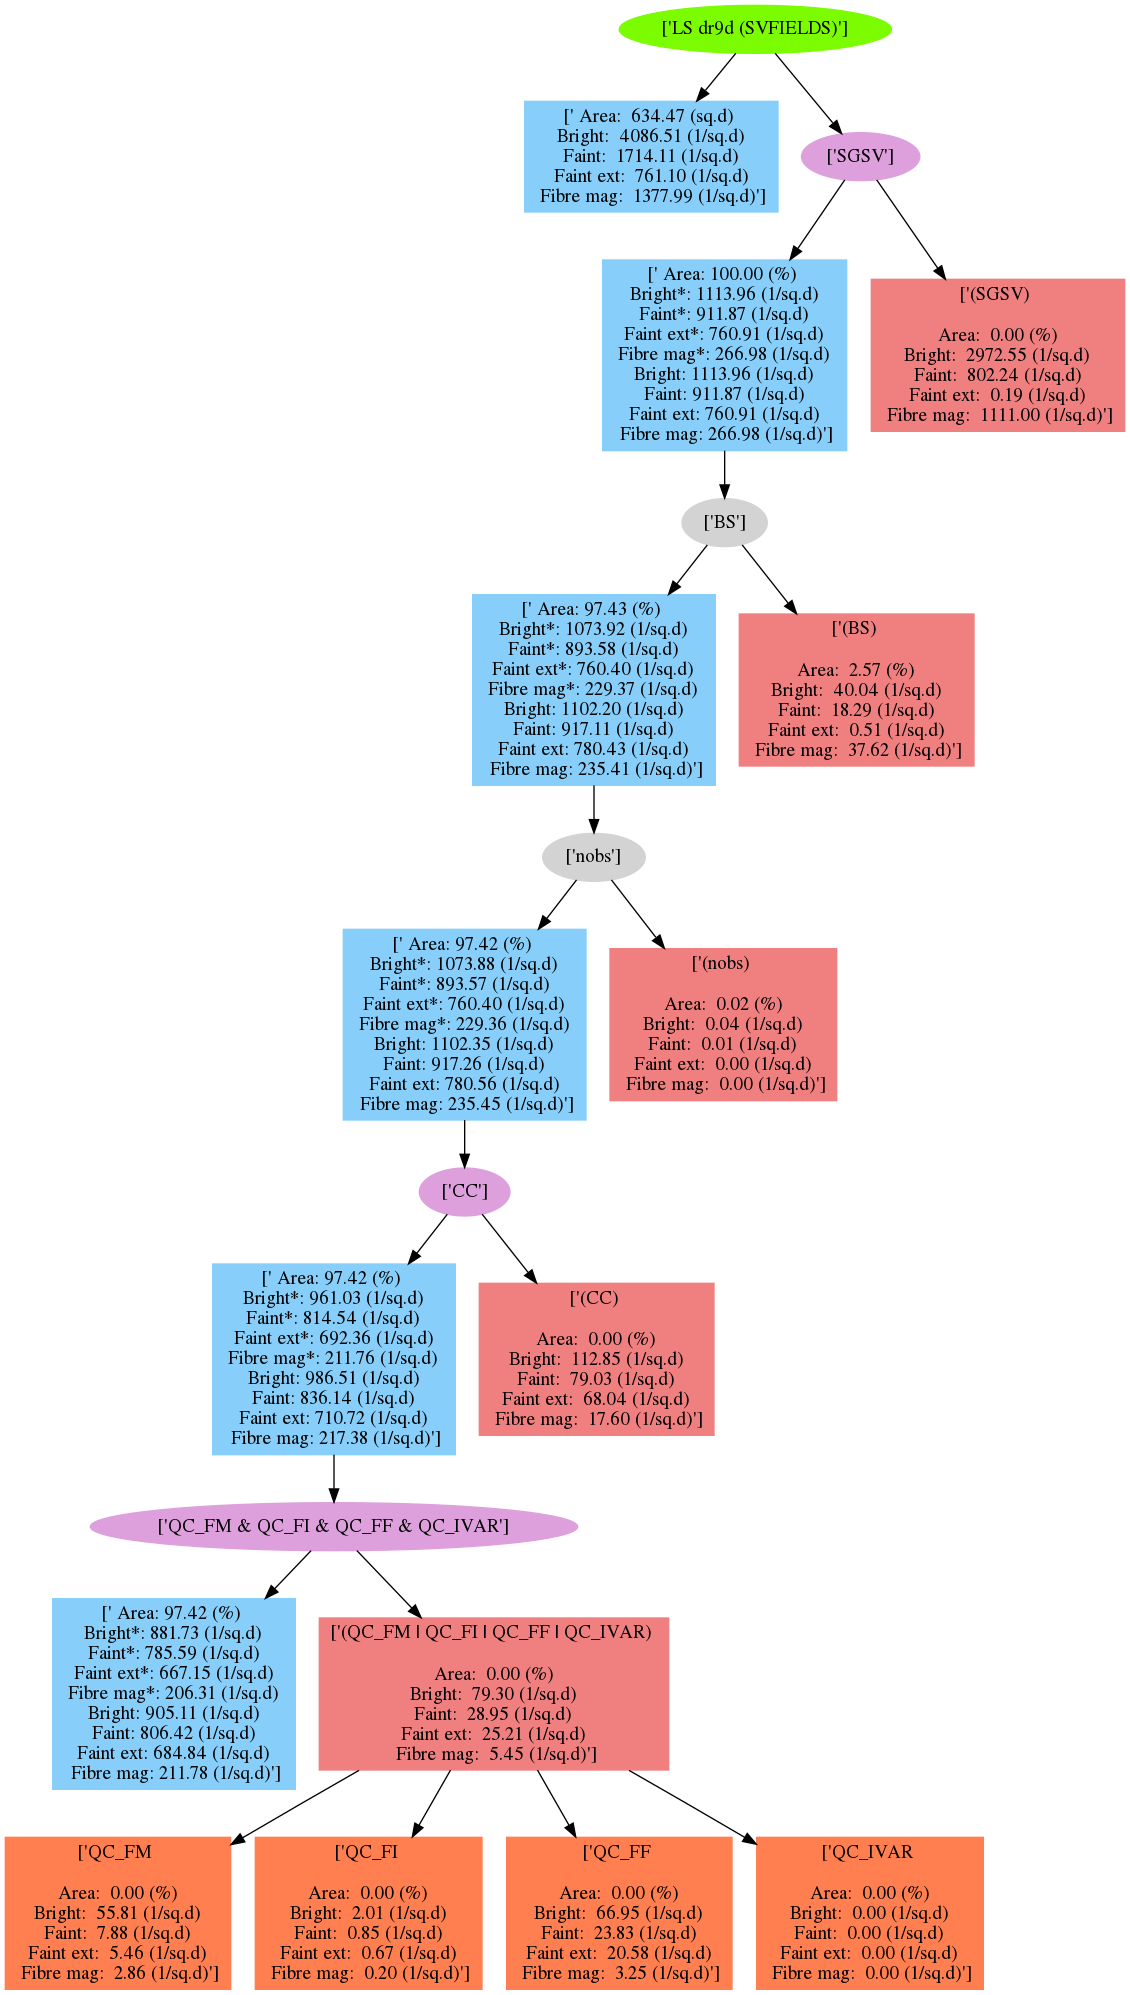

In [18]:
#
order = [['SGSV'], ['BS'], ['nobs'], ['CC'], ['QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']]
#order = [['SG'], ['BS', 'MS'], ['FMC', 'CC']]
flowphot, _, _ = flow(cat=cat, hpdict=hpdict, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=reg, 
             regcat=catinreg, regran=raninreg, file='flow_sv_%s_galview' %(dr), dr=dr, program='sv')

flowphot

### Next steep

* Modify cuts.py to include SV
* update the FMC and add the LSLGA manually in cuts.py
* modify getStats and flow to include SV

* Make sanity check plots
    * 
* Get match with GAMA results (for the main selection)
    * Venn diagram of LS vs BGS vs GAMA
    * N(z) of BGS & GAMA
    * N(z) of ~BGS & GAMA
    * rmag - r_petro vs rmag plots per tractor morpho
    

# DEV ZONE

## Comparing DESITARGET BGS with MYCAT BGS in SOUTH
The issue we had of the high densities at DES region has dissapear using `MYCAT` for the south only. Previous `MYCAT` catalogue includes `north` and `south` merged, that creates issues in the non-resolved north/south overlaped region where we have many repeated objects. The main issue was that the `north` has leacked some objects in the `south` explaining the issue we had before. 

When comparing both BGS catalogues (`DESITARGET` and `MYCAT`) in the `south` we still found some differences of the order of $\sim 1000$ objects. The differences are due a small gap in the north as seen in plots.

In [79]:
import fitsio
desit_dr8_s = '/global/cscratch1/sd/qmxp55/desitarget_output/targets-dr8.0-south/targets/main/resolve/bright/targets-dr8-hp-X.fits'
catdt_s = fitsio.read(desit_dr8_s)

In [80]:
hppix_cat2 = hp.ang2pix(nside,(90.-catdt_s['DEC'])*np.pi/180.,catdt_s['RA']*np.pi/180.,nest=True) # catalogue hp pixels array

In [81]:
catindesi2 = get_reg(reg='desi', hppix=hppix_cat2)
catinreg_2 = get_reg(reg=reg, hppix=hppix_cat2)
catinreg2 = (catindesi2) & (catinreg_2)    

In [82]:
bgsfdt_s = (catdt_s['BGS_TARGET'] & 2**(0)) != 0
bgsbdt_s = (catdt_s['BGS_TARGET'] & 2**(1)) != 0

In [109]:
bgsb2 = (catinreg2) & (bgsbdt_s)
bgsf2 = (catinreg2) & (bgsfdt_s)

mask1 = catdt_s['DEC'] < 40
mask2 = cat['DEC'] < 40

print(np.sum(bgsb2 & mask1), np.sum(bgsf2 & mask1))
print(np.sum(bgs_bright & mask2), np.sum(bgs_faint & mask2))

7947324 5432086
7948713 5433098


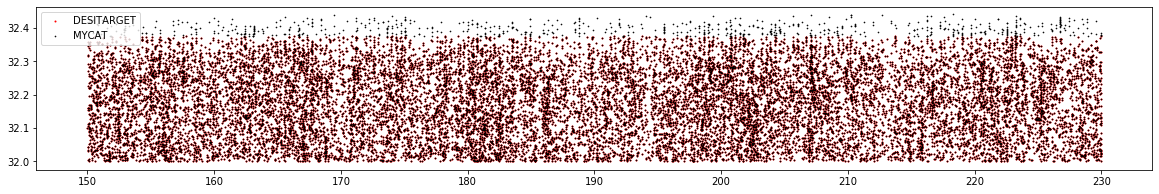

In [99]:
plt.figure(figsize=(20, 3))
mask1 = (cat['RA'] > 150) & (cat['RA'] < 230) & (cat['DEC'] > 32) & (cat['DEC'] < 34)
mask2 = (catdt_s['RA'] > 150) & (catdt_s['RA'] < 230) & (catdt_s['DEC'] > 32) & (catdt_s['DEC'] < 34)

plt.scatter(catdt_s[bgsb2 & mask2]['RA'][::1], catdt_s[bgsb2 & mask2]['DEC'][::1], s=1, c='r', label='DESITARGET')
plt.scatter(cat[bgs_bright & mask1]['RA'][::1], cat[bgs_bright & mask1]['DEC'][::1], s=0.4, c='k', label='MYCAT')

plt.legend()

In [116]:
from io_ import search_around
idx2, idx1, d2d, d_ra, d_dec = search_around(cat['RA'][bgs_bright], cat['DEC'][bgs_bright], 
                                                       catdt_s['RA'][bgsb2], catdt_s['DEC'][bgsb2], search_radius=0.01)

7947327 nearby objects


In [122]:
cattmp = cat[bgs_bright]

In [123]:
cat_matched = np.zeros_like(cattmp['RA'], dtype=bool)
cat_matched[idx2] = True

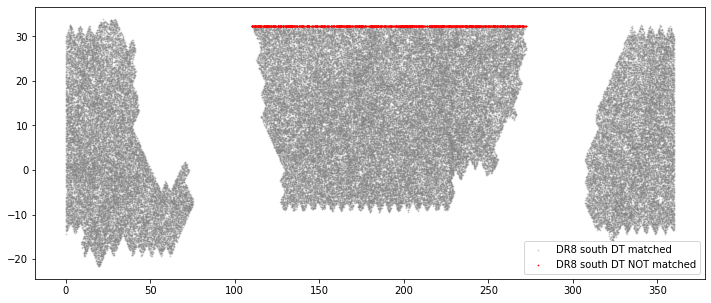

In [126]:
plt.figure(figsize=(12, 5))
plt.scatter(cattmp['RA'][cat_matched][::100], cattmp['DEC'][cat_matched][::100], s=0.8, c='gray', alpha=0.3, label='DR8 south DT matched')
plt.scatter(cattmp['RA'][~cat_matched], cattmp['DEC'][~cat_matched], s=0.5, c='r', alpha=1, label='DR8 south DT NOT matched')
plt.legend()
